In [1]:
#MRI data set up.
#1. Import TAR file
#2. Extract to a TestData and TrainData folder.



import tarfile
import os
import numpy as np


tar_path = "D:\Code\TestData\knee_singlecoil_test.tar"
# Destination directory to extract to
test_path = "D:\Code\TestData\knee-singlecoil\singlecoil_test"



In [2]:


# Count the number of files in the extracted directory
def count_files_in_directory(test_path):
    count = 0
    for root, dirs, files in os.walk(test_path):
        count += len(files)
    return count

# Count the files
file_count = count_files_in_directory(test_path)

print(f"Number of files in the directory: {count_files_in_directory(test_path)}")

# Extract
if len(os.listdir(test_path)) == 0: 
    print("Extracting TAR file...")
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=test_path)
    print("Extraction complete.")
else:
    print("Already extracted — skipping.")


Number of files in the directory: 108
Already extracted — skipping.


Keys: ['ismrmrd_header', 'kspace', 'mask']


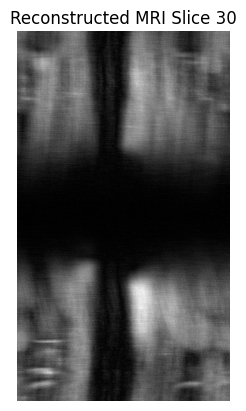

In [3]:
import h5py
import matplotlib.pyplot as plt
# Load the first .h5 file
file_path = os.path.join(test_path, os.listdir(test_path)[0])  # Get the first file in the list. File_path is defined by joining the data path
# and the first file name. Which returns the full path to the first file in the directory. This is done because
#the files variable is a list of lists, so we need to access the first element of the first list to get the file name.

with h5py.File(file_path, 'r') as f: #use h5py to read the file where 'r' means read-only and 'f' is the file object
    print("Keys:", list(f.keys()))  # Discover dataset structure
    kspace = f['kspace'][()]  # Load the k-space data

# Visualize one slice
slice_index = 30
image = np.fft.ifft2(kspace[slice_index])
image_abs = np.abs(image)

plt.imshow(image_abs, cmap='gray')
plt.title(f"Reconstructed MRI Slice {slice_index}")
plt.axis('off')
plt.show()


In [4]:
tar_path = "D:\Code\ValData\knee_singlecoil_val.tar"
# Destination directory to extract to
val_path = "D:\Code\ValData\singlecoil_val"



In [5]:

# Count the number of files in the extracted directory
def count_files_in_directory(val_path):
    count = 0
    for root, dirs, files in os.walk(val_path):
        count += len(files)
    return count

# Count the files
file_count = count_files_in_directory(val_path)

print(f"Number of files in the directory: {count_files_in_directory(test_path)}")

# Extract
if len(os.listdir(val_path)) == 0: 
    print("Extracting TAR file...")
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=val_path)
    print("Extraction complete.")
else:
    print("Already extracted — skipping.")

Number of files in the directory: 108
Already extracted — skipping.


Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']


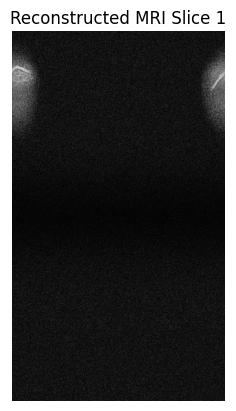

In [6]:
val_path = "D:\Code\ValData\singlecoil_val\singlecoil_val"

file_path = os.path.join(val_path, os.listdir(val_path)[0])  
with h5py.File(file_path, 'r') as f: #use h5py to read the file where 'r' means read-only and 'f' is the file object
    print("Keys:", list(f.keys()))  # Discover dataset structure
    kspace = f['kspace'][()]  # Load the k-space data

# Visualize one slice
slice_index = 1
image = np.fft.ifft2(kspace[slice_index])
image_abs = np.abs(image)

plt.imshow(image_abs, cmap='gray')
plt.title(f"Reconstructed MRI Slice {slice_index}")
plt.axis('off')
plt.show()


In [7]:
def create_variable_density_mask(kspace_shape, accel_factor, center_fraction):
    ny, nx = kspace_shape[-2], kspace_shape[-1]
    mask = np.zeros((ny, nx), dtype=np.float32)

    # Preserve central region (square box)
    center_ny = int(ny * center_fraction)
    center_nx = int(nx * center_fraction)
    y_start = ny // 2 - center_ny // 2
    x_start = nx // 2 - center_nx // 2
    mask[y_start:y_start + center_ny, x_start:x_start + center_nx] = 1

    # Add variable density sampling elsewhere (e.g. lines or radial-like pattern)
    num_total_samples = int(ny * nx / accel_factor)
    current_samples = int(mask.sum())

    while current_samples < num_total_samples:
        y = np.random.randint(0, ny)
        x = np.random.randint(0, nx)
        if mask[y, x] == 0:
            mask[y, x] = 1
            current_samples += 1

    return mask



#Define undersampling function as a function that takes the frequency domain k-space data and a mask as inputs,
#and returns the undersampled k-space data by multiplying the k-space data with the mask.

def simulate_undersampling(kspace, mask):
    undersampled_kspace =kspace * mask
    return undersampled_kspace



Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Shape of k-space data: (35, 640, 368)


(np.float64(-0.5), np.float64(367.5), np.float64(639.5), np.float64(-0.5))

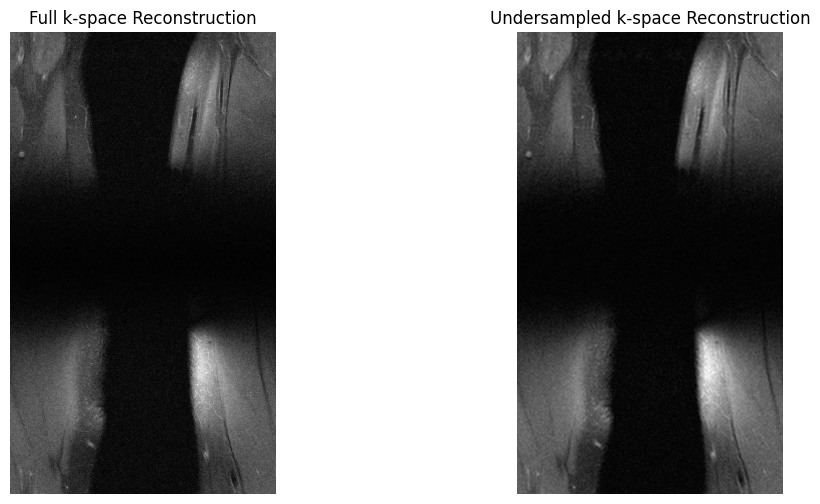

In [8]:
accel_factor = 3  # Acceleration factor
center_fraction = 0.4  # Fraction of central rows to preserve

#Visualize the undersampled k-space data vs the original k-space data.
file_path = os.path.join(val_path, os.listdir(val_path)[0])  
with h5py.File(file_path, 'r') as f: #use h5py to read the file where 'r' means read-only and 'f' is the file object
    print("Keys:", list(f.keys()))  # Discover dataset structure
    kspace = f['kspace'][()]  # Load the k-space data
    print("Shape of k-space data:", kspace.shape)  # Print the shape of the k-space data
    
slice_index = 34
kspace_slice = kspace[slice_index]

mask = create_variable_density_mask(kspace.shape, accel_factor, center_fraction)
undersampled = simulate_undersampling(kspace_slice, mask)

image_full = np.fft.ifft2(kspace_slice)
image_undersampled = np.fft.ifft2(undersampled)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image_full), cmap='gray')
plt.title("Full k-space Reconstruction")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.abs(image_undersampled), cmap='gray')
plt.title("Undersampled k-space Reconstruction")
plt.axis('off')
    


In [9]:
import torch
print(torch.cuda.is_available())  # Check if CUDA is available
print(torch.cuda.device_count())  # Count the number of available GPUs

False
0


In [11]:
import shutil
import random
import os
import h5py
import numpy as np

# Paths
val_data_dir = val_path  # already defined
# Define output directories for split data
output_base = "D:\\Code\\ValData\\split_data"
train_dir = os.path.join(output_base, "train")
val_dir = os.path.join(output_base, "val") 

# Clean folders
if os.path.exists(output_base):
    shutil.rmtree(output_base)

for base in [train_dir, val_dir]:
    for sub in ["original", "undersampled"]:
        os.makedirs(os.path.join(base, sub), exist_ok=True)

# List and shuffle
all_files = [f for f in os.listdir(val_data_dir) if f.endswith('.h5')]
random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]

# Helper: Apply undersampling to a file and save it
def process_file(src_path, dst_original, dst_undersampled):
    with h5py.File(src_path, 'r') as f:
        kspace = f['kspace'][()]
    # Save original
    shutil.copy2(src_path, dst_original)
    # Create one mask for the whole scan
    mask = create_variable_density_mask(kspace.shape, accel_factor=accel_factor, center_fraction=center_fraction)
    # Ensure mask is not all zeros
    if np.sum(mask) == 0:
        raise ValueError("Mask is all zeros! Check mask generation.")
    undersampled_kspace = simulate_undersampling(kspace, mask)
    # Save new .h5 file
    with h5py.File(dst_undersampled, 'w') as f:
        f.create_dataset("kspace", data=undersampled_kspace)

# Copy and undersample
def handle_files(file_list, dest_dir):
    for fname in file_list:
        src = os.path.join(val_data_dir, fname)
        dst_orig = os.path.join(dest_dir, "original", fname)
        dst_us = os.path.join(dest_dir, "undersampled", fname)
        process_file(src, dst_orig, dst_us)

handle_files(train_files, train_dir)
handle_files(val_files, val_dir)

print(f"✅ Split complete with accel_factor={accel_factor}, center_fraction={center_fraction}.")


✅ Split complete with accel_factor=3, center_fraction=0.4.


In [12]:

# DataLoader for training and validation datasets
class MRIDataset:
    def __init__(self, original_dir, undersampled_dir): 
        self.original_dir = original_dir
        self.undersampled_dir = undersampled_dir
        self.original_files = sorted([f for f in os.listdir(original_dir) if f.endswith('.h5')])
        self.undersampled_files = sorted([f for f in os.listdir(undersampled_dir) if f.endswith('.h5')])
        assert self.original_files == self.undersampled_files, "File mismatch between original and undersampled folders."

    def __len__(self):
        return len(self.original_files)

    def __getitem__(self, idx):
        original_path = os.path.join(self.original_dir, self.original_files[idx])
        undersampled_path = os.path.join(self.undersampled_dir, self.undersampled_files[idx])
        with h5py.File(original_path, 'r') as f:
            kspace = f['kspace'][()]
            slice_idx = kspace.shape[0] // 2
            original_slice = kspace[slice_idx]
        with h5py.File(undersampled_path, 'r') as f:
            kspace_us = f['kspace'][()]
            undersampled_slice = kspace_us[slice_idx]
        return undersampled_slice.astype(np.complex64), original_slice.astype(np.complex64)


In [13]:

import wandb
wandb.login(key="f537177fd3c24dd549ed7a74b3389fe1e03b8c42")
import tensorflow as tf
from tensorflow.keras import layers, models
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from numpy.fft import ifft2, ifftshift
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Hyperparameters and Paths ---
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

PROJECT_NAME = "MRI_CNN"
ENTITY = "convunet"

TRAIN_ORIG = train_dir + "/original"
TRAIN_US = train_dir + "/undersampled"
VAL_ORIG = val_dir + "/original"
VAL_US = val_dir + "/undersampled"

# --- Weights & Biases Logging ---
wandb.init(
    project=PROJECT_NAME,
    entity=ENTITY,
    config={
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "architecture": "3-block CNN",
        "input_type": "undersampled k-space to image space"
    }
)

# --- Utility: Convert k-space to image ---
def convert_kspace_to_image(kspace):
    image = np.abs(ifft2(ifftshift(kspace)))
    maxval = np.max(image)
    if maxval < 1e-8:
        return image
    return image / maxval

# --- Prepare dataset: Converts k-space pairs to normalized images for training ---
def prepare_dataset(dataset, target_size=(160, 160)):
    x = []
    y = []
    for i in range(len(dataset)):
        k_us, k_full = dataset[i]
        img_us = np.abs(ifft2(ifftshift(k_us)))
        img_gt = np.abs(ifft2(ifftshift(k_full)))
        img_us_resized = cv2.resize(img_us, target_size, interpolation=cv2.INTER_AREA)
        img_gt_resized = cv2.resize(img_gt, target_size, interpolation=cv2.INTER_AREA)
        # Normalize to [0, 1]
        min_us, max_us = np.min(img_us_resized), np.max(img_us_resized)
        min_gt, max_gt = np.min(img_gt_resized), np.max(img_gt_resized)
        img_us_resized = (img_us_resized - min_us) / (max_us - min_us + 1e-8)
        img_gt_resized = (img_gt_resized - min_gt) / (max_gt - min_gt + 1e-8)
        x.append(img_us_resized[..., np.newaxis])
        y.append(img_gt_resized[..., np.newaxis])
    return np.array(x), np.array(y)

# --- Loss: Combined MSE and SSIM for perceptual quality ---
def combined_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.3 * mse_loss + 0.7 * ssim_loss

# --- U-Net Denoiser Model ---
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D()(c3)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    # Decoder
    u3 = layers.UpSampling2D()(c4)
    u3 = layers.concatenate([u3, c3])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u3)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    u2 = layers.UpSampling2D()(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    u1 = layers.UpSampling2D()(c6)
    u1 = layers.concatenate([u1, c1])
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(32, 3, activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
    model = models.Model(inputs, outputs)
    return model


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\baggi\_netrc
wandb: Currently logged in as: sm2006 (convunet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:

# --- Data Preparation ---
train_dataset = MRIDataset(TRAIN_ORIG, TRAIN_US)
val_dataset = MRIDataset(VAL_ORIG, VAL_US)
x_train, y_train = prepare_dataset(train_dataset)
x_val, y_val = prepare_dataset(val_dataset)

# --- Model Training ---
EPOCHS = 12
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
model = build_unet(input_shape=x_train.shape[1:])

model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=['mae']
)

model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        WandbMetricsLogger(log_freq="epoch"),
        WandbModelCheckpoint(filepath="model.keras", save_best_only=True)
    ],
    verbose=1
)


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/12
40/40 ━━━━━━━━━━━━━━━━━━━━ 21:02 32s/step - loss: 0.7561 - mae: 0.38 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - loss: 0.7381 - mae: 0.3758 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - loss: 0.7091 - mae: 0.36 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - loss: 0.6819 - mae: 0.36 ━━━━━━━━━━━━━━━━━━━━ 1:19 2s/step - loss: 0.6571 - mae: 0.36 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - loss: 0.6349 - mae: 0.35 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - loss: 0.6153 - mae: 0.35 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - loss: 0.5975 - mae: 0.34 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - loss: 0.5819 - mae: 0.34 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - loss: 0.5684 - mae: 0.33 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - loss: 0.5562 - mae: 0.33 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - loss: 0.5448 - mae: 0.33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.5344 - mae: 0.3282 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 0.5249 - mae: 0.324 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.5163 - mae: 0.321 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 0.5082 - mae: 0.318 ━━

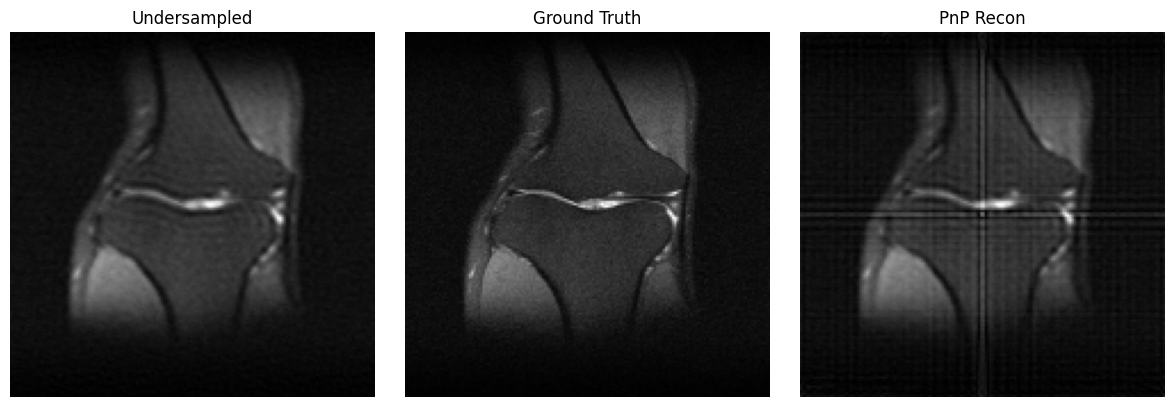

In [21]:
def pnp_reconstruction(y_kspace, mask, model, iterations=20):
    """
    Plug-and-Play MRI reconstruction.
    Alternates between data consistency in k-space and denoising in image space.
    Based on: Venkatakrishnan et al., GlobalSIP 2013; Zhang et al., CVPR 2018.
    """
    # Initial guess: zero-filled IFFT (use fftshift/ifftshift for consistency)
    x = np.fft.ifft2(np.fft.ifftshift(y_kspace))
    x = np.abs(x)
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)

    for _ in range(iterations):
        # Denoising step (U-Net expects [batch, H, W, 1])
        x_in = x[np.newaxis, ..., np.newaxis].astype(np.float32)
        x_dn = model.predict(x_in, verbose=0)[0, ..., 0]
        # Normalize output
        x_dn = (x_dn - x_dn.min()) / (x_dn.max() - x_dn.min() + 1e-8)
        # Data consistency step (use fftshift/ifftshift for consistency)
        x_dn_k = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x_dn)))
        x_dc_k = mask * y_kspace + (1 - mask) * x_dn_k
        x = np.abs(np.fft.ifft2(np.fft.ifftshift(x_dc_k)))
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x

# --- Confirm consistent transforms for GT and zero-filled ---
# Pick one random sample
idx = np.random.choice(len(x_val))
gt_img = y_val[idx].squeeze()
input_img = x_val[idx].squeeze()
# Consistent: get k-space from GT image, then reconstruct with ifft2/ifftshift
gt_kspace = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(gt_img)))
mask = create_variable_density_mask(gt_kspace.shape, accel_factor=accel_factor, center_fraction=center_fraction)
y_kspace = gt_kspace * mask

# Zero-filled reconstruction (consistent transform)
x_dc = np.abs(np.fft.ifft2(np.fft.ifftshift(y_kspace)))
x_dc = x_dc / (np.max(x_dc) + 1e-8)

# GT image (reconstructed from k-space, should match original gt_img up to global phase/scale)
gt_img_recon = np.abs(np.fft.ifft2(np.fft.ifftshift(gt_kspace)))
gt_img_recon = gt_img_recon / (np.max(gt_img_recon) + 1e-8)

# PnP reconstruction (using your model)
recon_img = pnp_reconstruction(y_kspace, mask, model, iterations=8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_dc, cmap='gray', vmin=0, vmax=1)
plt.title("Undersampled", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_img_recon, cmap='gray', vmin=0, vmax=1)
plt.title("Ground Truth", fontsize=12)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(recon_img, cmap='gray', vmin=0, vmax=1)
plt.title("PnP Recon", fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()


Undersampled vs Ground Truth: MSE=0.00059, MAE=0.01625, SSIM=0.8900
Recon vs Ground Truth:        MSE=0.00090, MAE=0.02023, SSIM=0.7839


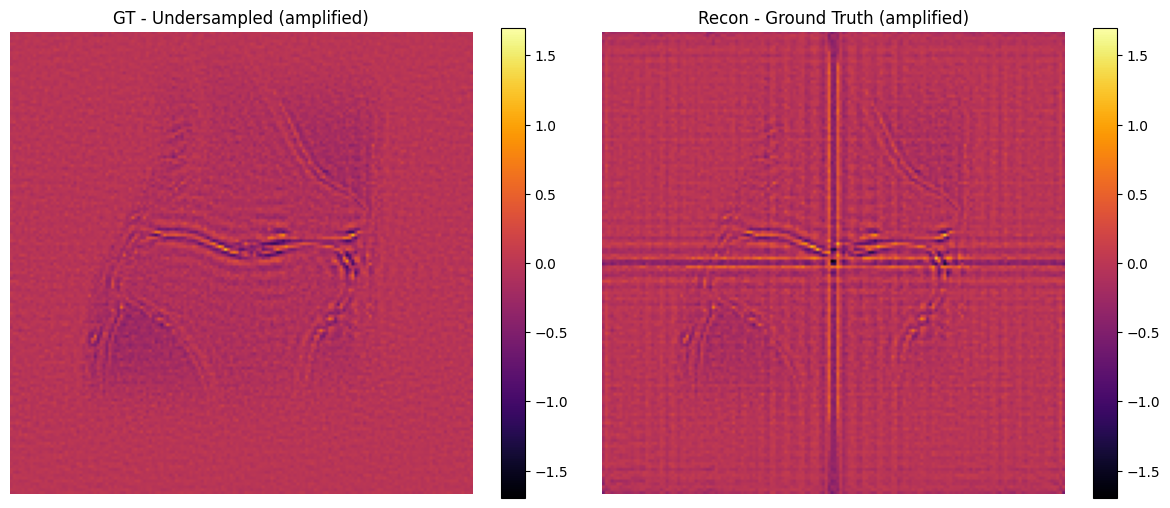

In [29]:
from skimage.metrics import structural_similarity as ssim

# Compute difference maps
diff_gt_us = gt_img_recon - x_dc
diff_recon_gt = -recon_img + gt_img_recon

# Quantitative metrics
mse_gt_us = np.mean((gt_img_recon - x_dc) ** 2)
mae_gt_us = np.mean(np.abs(gt_img_recon - x_dc))
ssim_gt_us = ssim(gt_img_recon, x_dc, data_range=1.0)

mse_gt = np.mean((recon_img - gt_img_recon) ** 2)
mae_gt = np.mean(np.abs(recon_img - gt_img_recon))
ssim_gt = ssim(recon_img, gt_img_recon, data_range=1.0)

print(f"Undersampled vs Ground Truth: MSE={mse_gt_us:.5f}, MAE={mae_gt_us:.5f}, SSIM={ssim_gt_us:.4f}")
print(f"Recon vs Ground Truth:        MSE={mse_gt:.5f}, MAE={mae_gt:.5f}, SSIM={ssim_gt:.4f}")

# Amplify differences for visualization
amplify = 5
diff_gt_us_vis = diff_gt_us * amplify
diff_recon_gt_vis = diff_recon_gt * amplify

# Set symmetric color limits
vmax = np.max(np.abs([diff_gt_us_vis, diff_recon_gt_vis]))
vmin = -vmax

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(diff_gt_us_vis, cmap='inferno', vmin=vmin, vmax=vmax)
plt.title("GT - Undersampled (amplified)")
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(diff_recon_gt_vis, cmap='inferno', vmin=vmin, vmax=vmax)
plt.title("Recon - Ground Truth (amplified)")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


In [30]:
import os

def count_unique_samples(base_dir):
    unique_files = set()
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.h5'):
                unique_files.add(file)
    print(f"Total unique samples in '{base_dir}': {len(unique_files)}")

count_unique_samples(output_base)

Total unique samples in 'D:\Code\ValData\split_data': 199


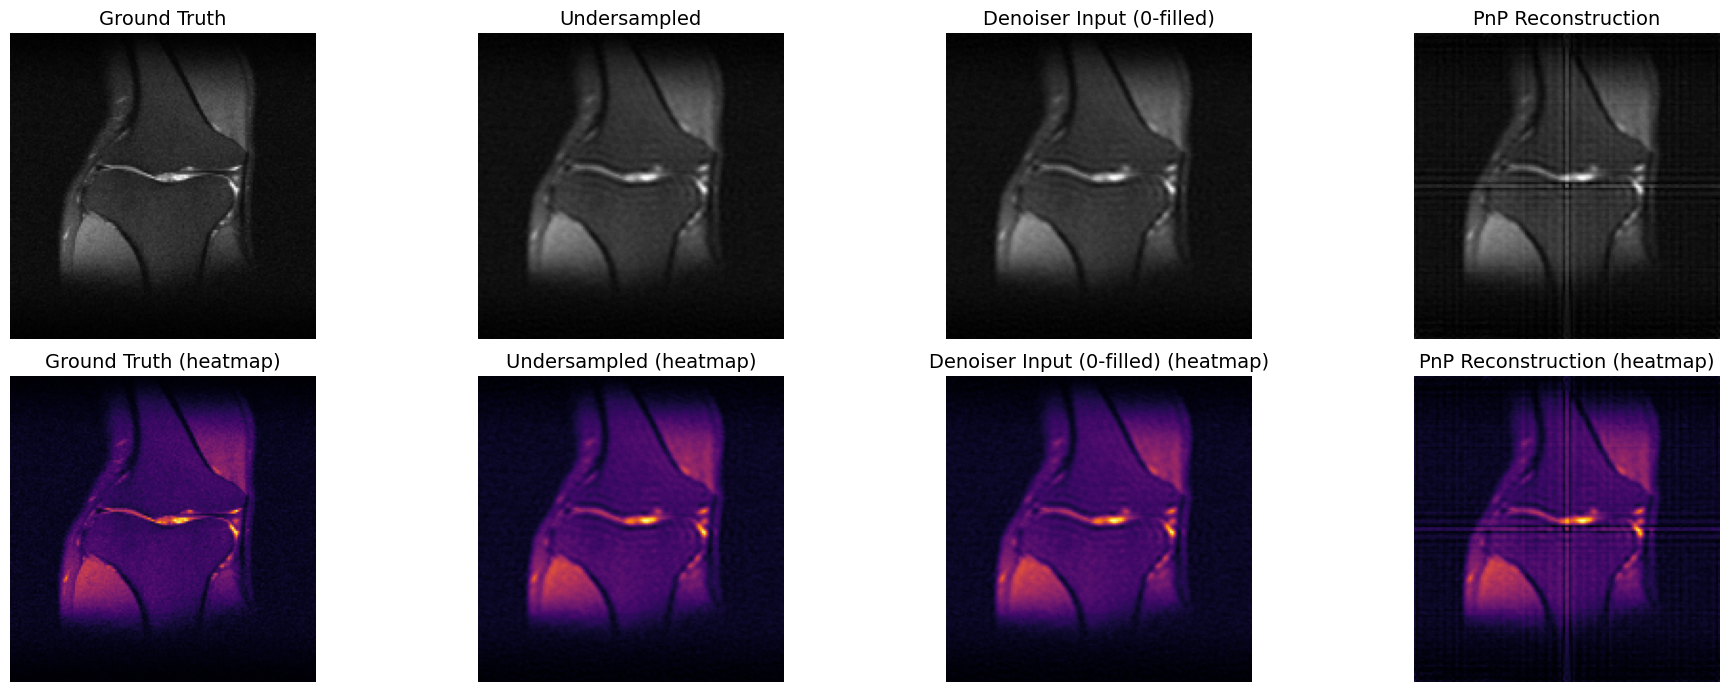

In [38]:
# Compute zero-filled image from undersampled k-space for display
input_img = np.abs(np.fft.ifft2(np.fft.ifftshift(y_kspace)))
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min() + 1e-8)

# Prepare images for plotting
images = [
    gt_img_recon,    # Ground Truth
    x_dc,            # Undersampled (zero-filled)
    input_img,       # Denoiser Input (proper 0-filled image)
    recon_img        # PnP Reconstruction
]
titles = [
    "Ground Truth",
    "Undersampled",
    "Denoiser Input (0-filled)",
    "PnP Reconstruction"
]

plt.figure(figsize=(20, 7))  # Larger figure

for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.title(title, fontsize=14)
    plt.axis('off')

for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 4, i + 5)
    plt.imshow(img, cmap='inferno')
    plt.title(title + " (heatmap)", fontsize=14)
    plt.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.08)  # Reduce space between plots
plt.tight_layout(pad=1.0)
plt.show()

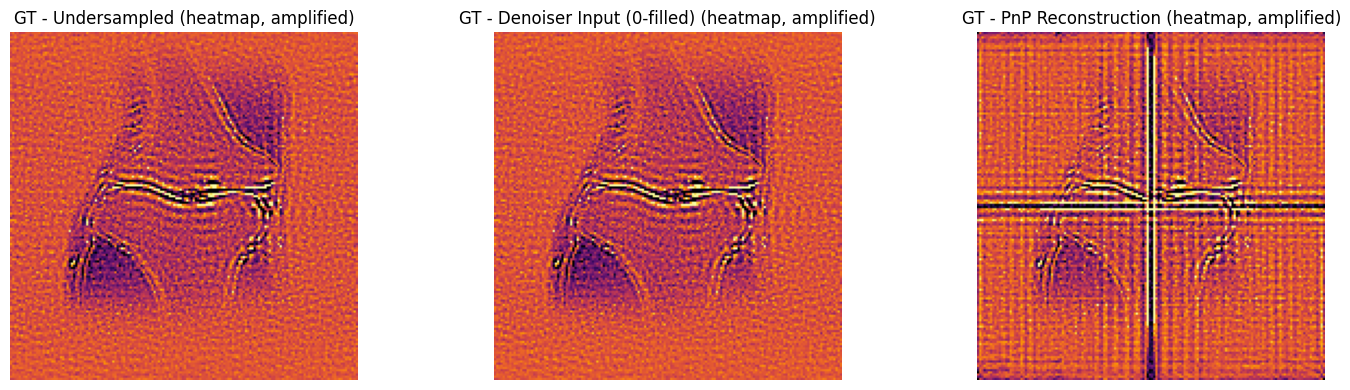

In [39]:
# Compute difference maps
diff_gt_us = gt_img_recon - x_dc
diff_gt_denoiser = gt_img_recon - input_img
diff_gt_recon = gt_img_recon - recon_img

diffs = [diff_gt_us, diff_gt_denoiser, diff_gt_recon]
titles_diff = [
    "GT - Undersampled",
    "GT - Denoiser Input (0-filled)",
    "GT - PnP Reconstruction"
]

# Amplify for visualization
amplify = 5  # Try higher values for more contrast
diffs_vis = [d * amplify for d in diffs]

# Use percentiles for color limits to enhance contrast
all_vals = np.concatenate([d.flatten() for d in diffs_vis])
vmin, vmax = np.percentile(all_vals, [1, 99])

plt.figure(figsize=(15, 4))
for i, (d, t) in enumerate(zip(diffs_vis, titles_diff)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d, cmap='inferno', vmin=vmin, vmax=vmax)
    plt.title(t + " (heatmap, amplified)")
    plt.axis('off')

plt.tight_layout()
plt.show()


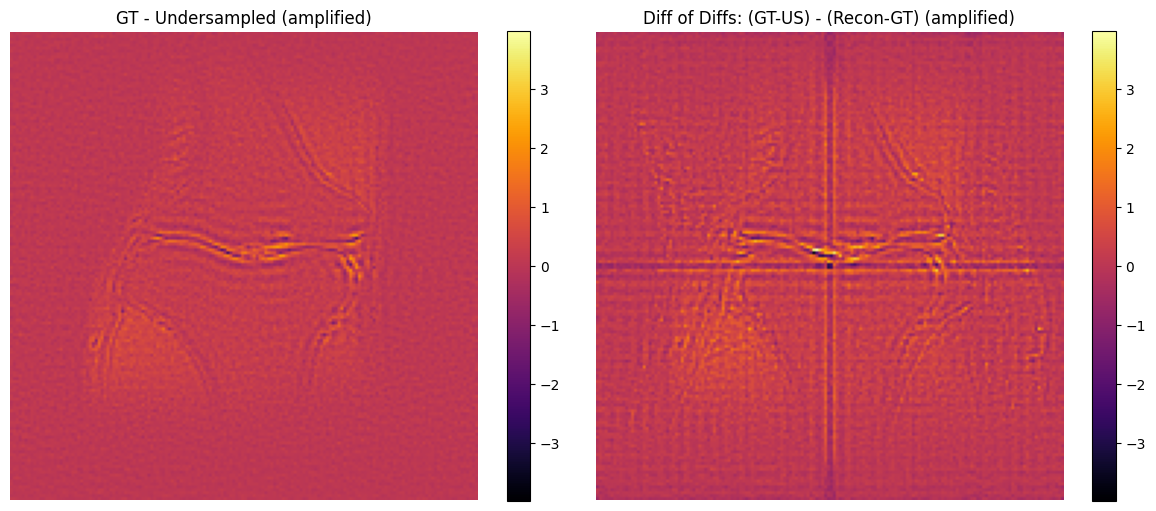

In [22]:
# Compute difference between ground truth and undersampled (zero-filled)
diff_gt_us = -gt_img_recon + x_dc

# Compute difference of differences: (GT - US) - (Recon - GT)
diff_tot = diff_gt_us - diff_recon_gt

# Amplify for visualization
amplify = 10
diff_gt_us_vis = diff_gt_us * amplify
diff_tot_vis = diff_tot * amplify

# Set symmetric color limits
vmax = np.max(np.abs([diff_gt_us_vis, diff_tot_vis]))
vmin = -vmax

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(diff_gt_us_vis, cmap='inferno', vmin=vmin, vmax=vmax)
plt.title("GT - Undersampled (amplified)")
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(diff_tot_vis, cmap='inferno', vmin=vmin, vmax=vmax)
plt.title("Diff of Diffs: (GT-US) - (Recon-GT) (amplified)")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dummy_input = np.random.rand(1, 320, 320, 1).astype(np.float32)
output = model.predict(dummy_input)
print("Dummy test - Output min/max:", output.min(), output.max())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/st ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Dummy test - Output min/max: 0.008599807 0.40358046


In [ ]:
# 1. Check if your input data is nonzero and normalized
print("Input min/max:", x_train.min(), x_train.max())
print("GT min/max:", y_train.min(), y_train.max())


Input min/max: 0.0 0.99627686
GT min/max: 0.0 0.99626845
